# Detecting and Analyzing Faces

Computer vision solutions often require an artificial intelligence (AI) solution to be able to detect, analyze, or identify human faces. or example, suppose the retail company Northwind Traders has decided to implement a "smart store", in which AI services monitor the store to identify customers requiring assistance, and direct employees to help them. One way to accomplish this is to perform facial detection and analysis - in other words, determine if there are any faces in the images, and if so analyze their features.

<p style='text-align:center'><img src='./images/face_analysis.jpg' alt='A robot analyzing a face'/></p>

## Use the Face cognitive service to detect faces

Suppose the smart store system that Northwind Traders wants to create needs to be able to detect customers and analyze their facial features. In Microsoft Azure, you can use the **Face** cognitive service to do this.

Let's start by creating a **Cognitive Services** resource in your Azure subscription.

> **Note**: If you already have a Cognitive Services resource, just open its **Quick start** page in the Azure portal and copy its key and endpoint to the cell below. Otherwise, follow the steps below to create one.

1. In another browser tab, open the Azure portal at https://portal.azure.com, signing in with your Microsoft account.
2. Click the **&#65291;Create a resource** button, search for *Cognitive Services*, and create a **Cognitive Services** resource with the following settings:
    - **Name**: *Enter a unique name*.
    - **Subscription**: *Your Azure subscription*.
    - **Location**: *Choose any available region*:
    - **Pricing tier**: S0
    - **Resource group**: *Create a resource group with a unique name*.
3. Wait for deployment to complete. Then go to your cognitive services resource, and on the **Quick start** page, note the keys and endpoint. You will need these to connect to your cognitive services resource from client applications.
4. Copy the **Key1** for your resource and paste it in the code below, replacing **YOUR_COG_KEY**.
5. Copy the **endpoint** for your resource and and paste it in the code below, replacing **YOUR_COG_ENDPOINT**.
6. Run the code in the cell below by clicking its green <span style="color:green">&#9655</span> button (at the top left of the cell).

In [1]:
cog_key = '5a87e1b77db641e195a49da6b09cf5a5'
cog_endpoint = 'https://uksouth.api.cognitive.microsoft.com/'

print('Ready to use cognitive services at {} using key {}'.format(cog_endpoint, cog_key))

Ready to use cognitive services at https://uksouth.api.cognitive.microsoft.com/ using key 5a87e1b77db641e195a49da6b09cf5a5


Now that you have a Cognitive Services resource, you can use the Face service to detect human faces in the store.

Run the code cell below to see an example.

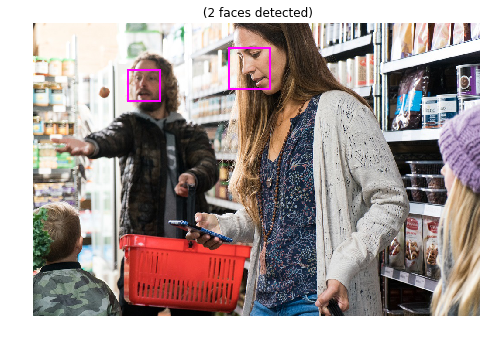

In [2]:
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from python_code import faces
import os
%matplotlib inline

# Create a face detection client.
face_client = FaceClient(cog_endpoint, CognitiveServicesCredentials(cog_key))

# Open an image
image_path = os.path.join('data', 'face', 'store_cam2.jpg')
image_stream = open(image_path, "rb")

# Detect faces
detected_faces = face_client.face.detect_with_stream(image=image_stream)

# Display the faces (code in python_code/faces.py)
faces.show_faces(image_path, detected_faces)

Each detected face is assigned a unique ID, so your application can identify each individual face that was detected.

Run the cell below to see the IDs for some more shopper faces.

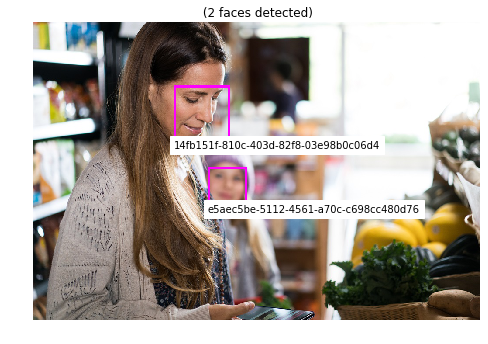

In [3]:
# Open an image
image_path = os.path.join('data', 'face', 'store_cam3.jpg')
image_stream = open(image_path, "rb")

# Detect faces
detected_faces = face_client.face.detect_with_stream(image=image_stream)

# Display the faces (code in python_code/faces.py)
faces.show_faces(image_path, detected_faces, show_id=True)

## Analyze facial attributes

The Face cognitive service can do much more than simply detect faces. It can also analyze facial features and expressions to suggest gender, age, and emotional state; For example, run the code below to analyze the facial attributes of a shopper.

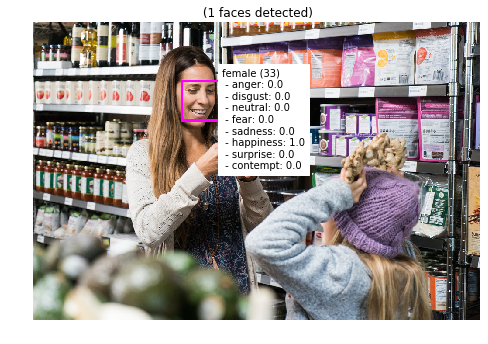

In [4]:
# Open an image
image_path = os.path.join('data', 'face', 'store_cam1.jpg')
image_stream = open(image_path, "rb")

# Detect faces and specified facial attributes
attributes = ['age', 'gender', 'emotion']
detected_faces = face_client.face.detect_with_stream(image=image_stream, return_face_attributes=attributes)

# Display the faces and attributes (code in python_code/faces.py)
faces.show_face_attributes(image_path, detected_faces)

Based on the emotion scores detected for the customer in the image, she seems pretty happy with her shopping experience.

## Find similar faces

The face IDs that are created for each detected face are used to individually identify face detections. You can use these IDs to compare a detected face to previously detected faces and find faces with similar features.

For example, run the cell below to compare the shopper in one image with shoppers in another, and find a matching face.

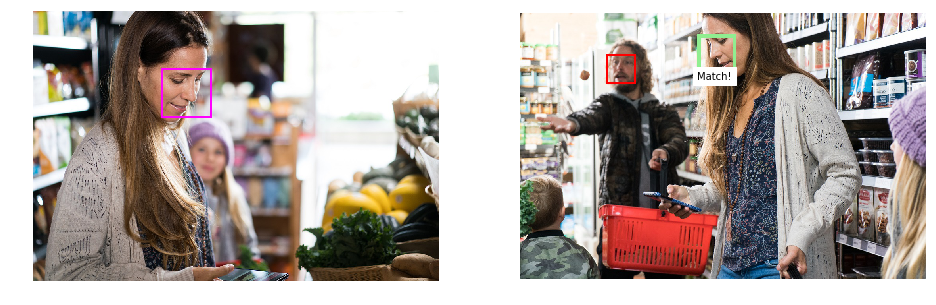

In [5]:
# Get the ID of the first face in image 1
image_1_path = os.path.join('data', 'face', 'store_cam3.jpg')
image_1_stream = open(image_1_path, "rb")
image_1_faces = face_client.face.detect_with_stream(image=image_1_stream)
face_1 = image_1_faces[0]

# Get the face IDs in a second image
image_2_path = os.path.join('data', 'face', 'store_cam2.jpg')
image_2_stream = open(image_2_path, "rb")
image_2_faces = face_client.face.detect_with_stream(image=image_2_stream)
image_2_face_ids = list(map(lambda face: face.face_id, image_2_faces))

# Find faces in image 2 that are similar to the one in image 1
similar_faces = face_client.face.find_similar(face_id=face_1.face_id, face_ids=image_2_face_ids)

# Show the face in image 1, and similar faces in image 2(code in python_code/face.py)
faces.show_similar_faces(image_1_path, face_1, image_2_path, image_2_faces, similar_faces)

## Recognize faces

So far you've seen that the Face service can detect faces and facial features, and can identify two faces that are similar to one another. You can take things a step further by inplementing a *facial recognition* solution in which you train your Face service resource to recognize a specific person's face. This can be useful in a variety of scenarios, such as automatically tagging photographs of friends in a social media application, or using facial recognition as part of a biometric identity verification system.

To see how this works, let's suppose the Northwind Traders company wants to use facial recognition to ensure that only authorized employees in the IT department can access secure systems.

We'll start by creating a *person group* to represent the authorized employees.

In [6]:
group_id = 'employee_group_id'
try:
    # Delete group if it already exists
    face_client.person_group.delete(group_id)
except Exception as ex:
    print(ex.message)
finally:
    face_client.person_group.create(group_id, 'employees')
    print ('Group created!')

(PersonGroupNotFound) Person group is not found.
Parameter name: personGroupId
Group created!


Now that the *person group* exists, we can add a *person* for each employee we want to include in the group, and then register multiple photographs of each person so that the Face service can learn the distinct facial characetristics of each person. Ideally, the images should show the same person in different poses and witjh different facial expressions.

We'll add a single employee called Wendell, and register three photographs of him.

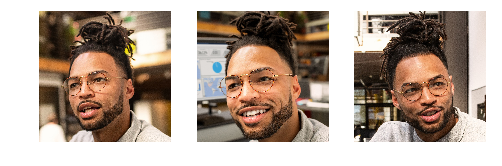

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

# Add a person (Wendell) to the group
wendell = face_client.person_group_person.create(group_id, 'Wendell')

# Get photo's of Wendell
folder = os.path.join('data', 'face', 'wendell')
wendell_pics = os.listdir(folder)

# Register the photos
i = 0
fig = plt.figure(figsize=(8, 8))
for pic in wendell_pics:
    # Add each photo to person in person group
    img_path = os.path.join(folder, pic)
    img_stream = open(img_path, "rb")
    face_client.person_group_person.add_face_from_stream(group_id, wendell.person_id, img_stream)

    # Display each image
    img = Image.open(img_path)
    i +=1
    a=fig.add_subplot(1,len(wendell_pics), i)
    a.axis('off')
    imgplot = plt.imshow(img)
plt.show()

With the person added, and photographs registered, we can now train the Face service to recognize each person.

In [8]:
face_client.person_group.train(group_id)
print('Trained!')

Trained!


Now, with the model trained, you can use it to identify recognized faces in an image.

In [ ]:
# Get the face IDs in a second image
image_path = os.path.join('data', 'face', 'employees.jpg')
image_stream = open(image_path, "rb")
image_faces = face_client.face.detect_with_stream(image=image_stream)
image_face_ids = list(map(lambda face: face.face_id, image_faces))

# Get recognized face names
face_names = {}
recognized_faces = face_client.face.identify(image_face_ids, group_id)
for face in recognized_faces:
    person_name = face_client.person_group_person.get(group_id, face.candidates[0].person_id).name
    face_names[face.face_id] = person_name

# show recognized faces
faces.show_recognized_faces(image_path, image_faces, face_names)



## Learn More

To learn more about the Face cognitive service, see the [Face documentation](https://docs.microsoft.com/azure/cognitive-services/face/)
